In [45]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D
from skimage import io
from glob import glob
from tqdm import tqdm


In [79]:
#import zipfile
#with zipfile.ZipFile('../input/test-data.zip', 'r') as zip_ref:
    #zip_ref.extractall('../input/test-d')

train_path="../input/traindata/"
val_path='../input/testdata/'
mcc_path='../input/mcc-test/'

train_images=[]
train_masks=[]
val_images=[]
val_masks=[]
mcc_images=[]
def load_images(path):
    temp_img,temp_mask=[],[]
    images=glob(os.path.join(path,'*.png'))
    for i in tqdm(images):
        i=cv2.imread(i)
        i=cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        i=cv2.normalize(i,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        
        img=i[:,:256]
        msk=i[:,256:]  
        temp_img.append(img)
        temp_mask.append(msk)
    return temp_img,temp_mask

def load_mcc_images(path):
    temp_img,temp_mask=[],[]
    images=glob(os.path.join(path,'*.png'))
    for i in tqdm(images):
        i=cv2.imread(i)
        i=cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        i=cv2.normalize(i,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        
        img=i[:,:512] 
        temp_img.append(img)
    return temp_img

train_images,train_masks=load_images(train_path)
val_images,val_masks=load_images(val_path)
mcc_images=load_mcc_images(mcc_path)


100%|██████████| 7/7 [00:00<00:00, 85.50it/s]


(256, 512, 3)
810


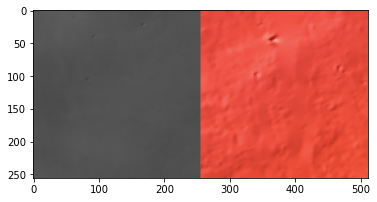

In [83]:
#Reading data. Before running this code, the dataset should be added to the notebook using the Kaggle functionality (or by any other means). In this block we read the first image
#and make sure everything works
path = '../input/traindata/'
flist = os.listdir(path)

img0 = cv2.cvtColor(cv2.imread(path+flist[0]),cv2.COLOR_BGR2RGB)

plt.imshow(img0)
print(np.shape(img0))
print(len(flist))

In [49]:
#reading the actual images and forming them into the training dataset
szy,szx,_ = np.shape(img0)
N_ex = 1500
N_bias = 0
x_train = np.zeros((N_ex,szy,int(szx/2),3))
y_train = np.zeros((N_ex,szy,int(szx/2),3))
k = 0;

for f in flist[N_bias:N_bias+N_ex]:
    x_train[k] = cv2.cvtColor(cv2.imread(path+f),cv2.COLOR_BGR2RGB)[:,:256]/256
    y_train[k] = cv2.cvtColor(cv2.imread(path+f),cv2.COLOR_BGR2RGB)[:,256:]/256
    k = k+1

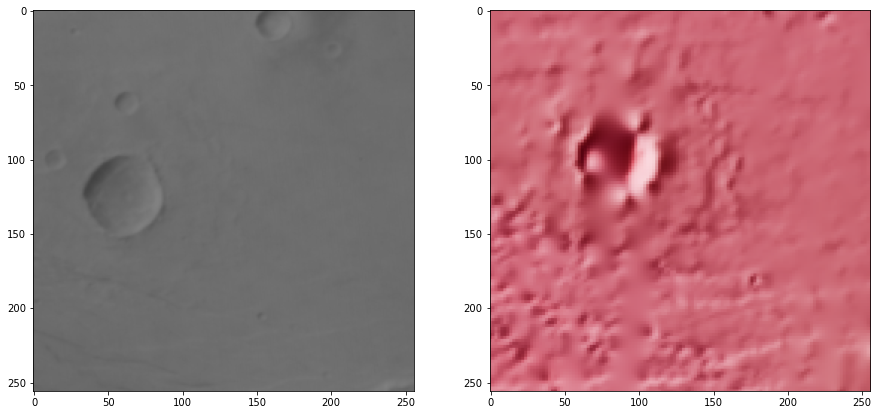

In [50]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(x_train[1])
plt.subplot(1,2,2)
plt.imshow(y_train[1])

In [51]:
#same for the validation data
path = '../input/testdata/'
flist = os.listdir(path)
img0 = cv2.imread(path+flist[0])
N_val = 100

szy,szx,_ = np.shape(img0)
x_val = np.zeros((N_val,szy,int(szx/2),3))
y_val = np.zeros((N_val,szy,int(szx/2),3))
k = 0;

for f in flist[0:N_val]:
    x_train[k] = cv2.cvtColor(cv2.imread(path+f),cv2.COLOR_BGR2RGB)[:,:256]/256
    y_train[k] = cv2.cvtColor(cv2.imread(path+f),cv2.COLOR_BGR2RGB)[:,256:]/256
    k = k+1

In [52]:
#u-net architecture
import tensorflow as tf
import keras

from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.layers.convolutional import Conv2D
from keras.models import Sequential, Model, model_from_json, load_model
from keras.regularizers import l2


# define conv_factory: batch normalization + ReLU + Conv2D + Dropout (optional)
def conv_factory(x, concat_axis, nb_filter,
                 dropout_rate=None, weight_decay=1E-4):
    x = BatchNormalization(axis=concat_axis,
                           gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (5, 5), dilation_rate=(2, 2),
               kernel_initializer="he_uniform",
               padding="same",
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
  
    return x


# define dense block: a nb_layers stack of conv_factory layers merged together
def denseblock(x, concat_axis, nb_layers, growth_rate, dropout_rate=None, weight_decay=1E-4):
    list_feat = [x]
    for i in range(nb_layers):
        x = conv_factory(x, concat_axis, growth_rate,dropout_rate, weight_decay)
        list_feat.append(x)
    x = Concatenate(axis=concat_axis)(list_feat)

    return x


# define model U-net modified with dense block
def u_net():
    dr = 0.5
    nr = 2
    mod_inputs = Input((256,256,3))
    print("inputs shape:", mod_inputs.shape) #input layer

    conv1 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mod_inputs)
    print("conv1 shape:", conv1.shape)
    db1 = denseblock(x=conv1, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db1 shape:", db1.shape)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)
    print("pool1 shape:", pool1.shape)

    conv2 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    print("conv2 shape:", conv2.shape)
    db2 = denseblock(x=conv2, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db2 shape:", db2.shape)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)
    print("pool2 shape:", pool2.shape)

    conv3 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    print("conv3 shape:", conv3.shape)
    db3 = denseblock(x=conv3, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db3 shape:", db3.shape)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)
    print("pool3 shape:", pool3.shape)

    conv4 = Conv2D(512/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    print("conv4 shape:", conv4.shape)
    db4 = denseblock(x=conv4, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db4 shape:", db4.shape)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)
    print("pool4 shape:", pool4.shape)
#################this is the bottleneck######################################
    conv5 = Conv2D(1024/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    print("conv5 shape:", conv5.shape)
    db5 = denseblock(x=conv5, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db5.shape)
    up5 = Conv2D(512/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db5))
    print("up5 shape:", up5.shape)
    merge5 = Concatenate(axis=3)([ BatchNormalization()(db4), BatchNormalization()( up5)]) #skip connection db4 to up5
    print("merge5 shape:", merge5.shape)

    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    print("conv6 shape:", conv6.shape)
    db6 = denseblock(x=conv6, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db6.shape)
    up6 = Conv2D(256/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db6))
    print("up6 shape:", up6.shape)
    merge6 = Concatenate(axis=3)([BatchNormalization()(db3), BatchNormalization()(up6)]) #skip connection db3 to up6
    print("merge6 shape:", merge6.shape)

    conv7 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    print("conv7 shape:", conv7.shape)
    db7 = denseblock(x=conv7, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db7 shape:", db7.shape)
    up7 = Conv2D(128/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db7))
    print("up7 shape:", up7.shape)
    merge7 = Concatenate(axis=3)([BatchNormalization()(db2), BatchNormalization()(up7)]) #skip connection db2 to up7
    print("merge7 shape:", merge7.shape)

    conv8 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    print("conv8 shape:", conv8.shape)
    db8 = denseblock(x=conv8, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db8 shape:", db8.shape)
    up8 = Conv2D(64/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db8))
    print("up8 shape:", up8.shape)
    merge8 = Concatenate(axis=3)([BatchNormalization()(db1), BatchNormalization()(up8)]) #skip connection db1 to up8
    print("merge8 shape:", merge8.shape)

    conv9 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    print("conv9 shape:", conv9.shape)
    db9 = denseblock(x=conv9, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db9 shape:", db9.shape)
    conv10 = Conv2D(32/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db9) # final node layer
    print("conv10 shape:", conv10.shape)
    conv11 = Conv2D(3, 1, activation='sigmoid')(conv10)  #output layer matched in size with the input
    print("conv11 shape:", conv11.shape)

    model = Model(inputs=mod_inputs, outputs=conv11) 
    model.compile(optimizer='adam', loss = 'MSE')
    
    return model

In [53]:
model = u_net()

inputs shape: (None, 256, 256, 3)
conv1 shape: (None, 256, 256, 32)
db1 shape: (None, 256, 256, 96)
pool1 shape: (None, 128, 128, 96)
conv2 shape: (None, 128, 128, 64)
db2 shape: (None, 128, 128, 128)
pool2 shape: (None, 64, 64, 128)
conv3 shape: (None, 64, 64, 128)
db3 shape: (None, 64, 64, 192)
pool3 shape: (None, 32, 32, 192)
conv4 shape: (None, 32, 32, 256)
db4 shape: (None, 32, 32, 320)
pool4 shape: (None, 16, 16, 320)
conv5 shape: (None, 16, 16, 512)
db5 shape: (None, 16, 16, 560)
up5 shape: (None, 32, 32, 256)
merge5 shape: (None, 32, 32, 576)
conv6 shape: (None, 32, 32, 512)
db5 shape: (None, 32, 32, 560)
up6 shape: (None, 64, 64, 128)
merge6 shape: (None, 64, 64, 320)
conv7 shape: (None, 64, 64, 128)
db7 shape: (None, 64, 64, 160)
up7 shape: (None, 128, 128, 64)
merge7 shape: (None, 128, 128, 192)
conv8 shape: (None, 128, 128, 64)
db8 shape: (None, 128, 128, 96)
up8 shape: (None, 256, 256, 32)
merge8 shape: (None, 256, 256, 128)
conv9 shape: (None, 256, 256, 32)
db9 shape: (No

In [ ]:
model.summary()

In [92]:
hist = model.fit(np.array(train_images,dtype='float16'),np.array(train_masks,dtype='float16'),epochs= 40, batch_size= 20,
          validation_data=(np.array(val_images,dtype='float16'),np.array(val_masks,dtype='float16')))
tf.keras.models.save_model(model,'/kaggle/working/best_model2_e_40.h5')

Epoch 1/40
41/41 [==============================] - 27s 652ms/step - loss: 0.0587 - val_loss: 0.0631
Epoch 2/40
41/41 [==============================] - 27s 653ms/step - loss: 0.0551 - val_loss: 0.0594
Epoch 3/40
41/41 [==============================] - 27s 651ms/step - loss: 0.0532 - val_loss: 0.0575
Epoch 4/40
41/41 [==============================] - 27s 652ms/step - loss: 0.0503 - val_loss: 0.0629
Epoch 5/40
41/41 [==============================] - 27s 651ms/step - loss: 0.0479 - val_loss: 0.0536
Epoch 6/40
41/41 [==============================] - 27s 652ms/step - loss: 0.0468 - val_loss: 0.0501
Epoch 7/40
41/41 [==============================] - 27s 654ms/step - loss: 0.0449 - val_loss: 0.0486
Epoch 8/40
41/41 [==============================] - 27s 650ms/step - loss: 0.0433 - val_loss: 0.0464
Epoch 9/40
41/41 [==============================] - 27s 654ms/step - loss: 0.0413 - val_loss: 0.0671
Epoch 10/40
41/41 [==============================] - 27s 653ms/step - loss: 0.0406 - val_lo

In [ ]:
''' hist = model.fit(x_train, y_train, epochs=10, shuffle = True, batch_size= 10, validation_data=(x_val, y_val))'''

In [93]:

model.load_weights('./best_model2_e_40.h5')

In [94]:
def plot_imgs(img,mask,pred):
    mask = np.reshape(mask,(512,512,3))
    pred = np.reshape(pred,(512,512,3))
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask)
    ax2.axis('off')
    ax3.imshow(pred)
    ax3.axis('off')

In [102]:
pred_masks = model.predict(np.array(mcc_images,dtype='float16'))

In [103]:
print('-------------Input---------------Actual mask--------------Predicted mask-------')
for i in range(6):
    x = np.random.randint(0,6,size=1)[0]
    #print(x)
    plot_imgs(mcc_images[x],mcc_images[x],pred_masks[x])

-------------Input---------------Actual mask--------------Predicted mask-------


ValueError: cannot reshape array of size 786432 into shape (256,256,3)

In [ ]:
 pp = model.predict(np.array(val_images,dtype='float16'))

In [ ]:
def u_net_wihtout_skips():
    dr = 0.5
    nr = 2
    mod_inputs = Input((256,256,3))
    print("inputs shape:", mod_inputs.shape)

    conv1 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mod_inputs)
    print("conv1 shape:", conv1.shape)
    db1 = denseblock(x=conv1, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db1 shape:", db1.shape)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)
    print("pool1 shape:", pool1.shape)

    conv2 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    print("conv2 shape:", conv2.shape)
    db2 = denseblock(x=conv2, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db2 shape:", db2.shape)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)
    print("pool2 shape:", pool2.shape)

    conv3 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    print("conv3 shape:", conv3.shape)
    db3 = denseblock(x=conv3, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db3 shape:", db3.shape)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)
    print("pool3 shape:", pool3.shape)

    conv4 = Conv2D(512/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    print("conv4 shape:", conv4.shape)
    db4 = denseblock(x=conv4, concat_axis=3, nb_layers=4, growth_rate=16, dropout_rate=dr)
    print("db4 shape:", db4.shape)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)
    print("pool4 shape:", pool4.shape)
###############################################################################################################
    conv5 = Conv2D(1024/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    print("conv5 shape:", conv5.shape)
    db5 = denseblock(x=conv5, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db5.shape)
    up5 = Conv2D(512/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db5))
    print("up5 shape:", up5.shape)
    #merge5 = Concatenate(axis=3)([ BatchNormalization()(db4), BatchNormalization()( up5)])
    #print("merge5 shape:", merge5.shape)

    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up5) #was merge5
    print("conv6 shape:", conv6.shape)
    db6 = denseblock(x=conv6, concat_axis=3, nb_layers=3, growth_rate=16, dropout_rate=dr)
    print("db5 shape:", db6.shape)
    up6 = Conv2D(256/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(db6))
    print("up6 shape:", up6.shape)
    #merge6 = Concatenate(axis=3)([BatchNormalization()(db3), BatchNormalization()(up6)])
    #print("merge6 shape:", merge6.shape)

    conv7 = Conv2D(256/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)#was merge6
    print("conv7 shape:", conv7.shape)
    db7 = denseblock(x=conv7, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db7 shape:", db7.shape)
    up7 = Conv2D(128/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db7))
    print("up7 shape:", up7.shape)
    #merge7 = Concatenate(axis=3)([BatchNormalization()(db2), BatchNormalization()(up7)])
    #print("merge7 shape:", merge7.shape)

    conv8 = Conv2D(128/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7) #was merge7
    print("conv8 shape:", conv8.shape)
    db8 = denseblock(x=conv8, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db8 shape:", db8.shape)
    up8 = Conv2D(64/nr, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(db8))
    print("up8 shape:", up8.shape)
    #merge8 = Concatenate(axis=3)([BatchNormalization()(db1), BatchNormalization()(up8)])
    #print("merge8 shape:", merge8.shape)

    conv9 = Conv2D(64/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)#was merge8
    print("conv9 shape:", conv9.shape)
    db9 = denseblock(x=conv9, concat_axis=3, nb_layers=2, growth_rate=16, dropout_rate=dr)
    print("db9 shape:", db9.shape)
    conv10 = Conv2D(32/nr, 3, activation='relu', padding='same', kernel_initializer='he_normal')(db9)
    print("conv10 shape:", conv10.shape)
    conv11 = Conv2D(3, 1, activation='sigmoid')(conv10)
    print("conv11 shape:", conv11.shape)

    model = Model(inputs=mod_inputs, outputs=conv11)
    model.compile(optimizer='adam', loss = 'MSE')
    
    return model

In [ ]:
model_nc = u_net_wihtout_skips()

In [ ]:
model_nc.summary()

In [ ]:
his_nc = model_nc.fit(np.array(train_images,dtype='float16'),np.array(train_masks,dtype='float16'),epochs= 20, batch_size= 10,
          validation_data=(np.array(val_images,dtype='float16'),np.array(val_masks,dtype='float16')))
#tf.keras.models.save_model(model,'/kaggle/working/best_model2_e35.h5')

In [ ]:
#pp_nc = model_nc.predict(val_images[0:20,:,:,:])
pp_nc = model_nc.predict(np.array(val_images,dtype='float16'))

In [ ]:
ni = 10
for k in range(ni):

    plt.figure(figsize=(10,30))
    plt.subplot(ni,4,1+k*4)
    plt.imshow(x_val[k])
    plt.subplot(ni,4,2+k*4)
    plt.imshow(y_val[k])
    plt.subplot(ni,4,3+k*4)
    plt.imshow(pp_nc[k]) #without skips
    plt.subplot(ni,4,4+k*4)
    plt.imshow(pp[k]) #with skips

In [ ]:
#training mse
plt.plot(hist.history['loss'])
plt.plot(his_nc.history['loss'])

In [ ]:
#show the result
ni = 10
for k in range(ni):

    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_val[k])
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_val[k])
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pp[k])


In [ ]:
#validation mse
plt.plot(hist.history['val_loss'])
plt.plot(his_nc.history['val_loss'])